In [1]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from scipy.stats import pearsonr, spearmanr, linregress
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
import statistics

import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import *

In [2]:
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '20'
legend_font = '16'
title_font = '24'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]
gray = '#8b96ad'
red = '#c74546'
dark = 'k'

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data and QC

In [3]:
import spatialdata_io
import spatialdata_plot

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [4]:
sdata = spatialdata_io.xenium('/home/mffang/data/counts/10x/human_lymph_xenium_2024')
sdata

INFO     reading /home/mffang/data/counts/10x/human_lymph_xenium_2024/cell_feature_matrix.h5                       


/tmp/ipykernel_1209693/1259620986.py:1: DeprecationWarning: The default value of `cells_as_circles` will change to `False` in the next release. Please pass `True` explicitly to maintain the current behavior.
  sdata = spatialdata_io.xenium('/home/mffang/data/counts/10x/human_lymph_xenium_2024')


SpatialData object
├── Images
│     └── 'morphology_focus': DataTree[cyx] (5, 34119, 39776), (5, 17059, 19888), (5, 8529, 9944), (5, 4264, 4972), (5, 2132, 2486)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (34119, 39776), (17059, 19888), (8529, 9944), (4264, 4972), (2132, 2486)
│     └── 'nucleus_labels': DataTree[yx] (34119, 39776), (17059, 19888), (8529, 9944), (4264, 4972), (2132, 2486)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (708983, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (708983, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (702300, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (708983, 4624)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell_boundaries (Shapes), cell_circles (Shapes), nucleus_boundaries (Shap

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/tifffile/tifffile.py:8820: UserWarning: <tifffile.TiffPage 0 @16> reading array from closed file
  warnings.warn(
/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/tifffile/tifffile.py:8820: UserWarning: <tifffile.TiffPage 0 @16> reading array from closed file
  warnings.warn(


INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5634602076124566].


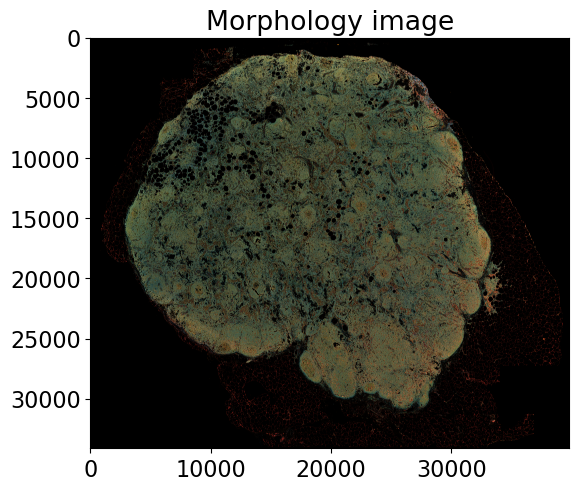

In [5]:
sdata.pl.render_images("morphology_focus").pl.show(title="Morphology image")

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/spatialdata/_core/spatialdata.py:511: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)


INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5634602076124566].
/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwr

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


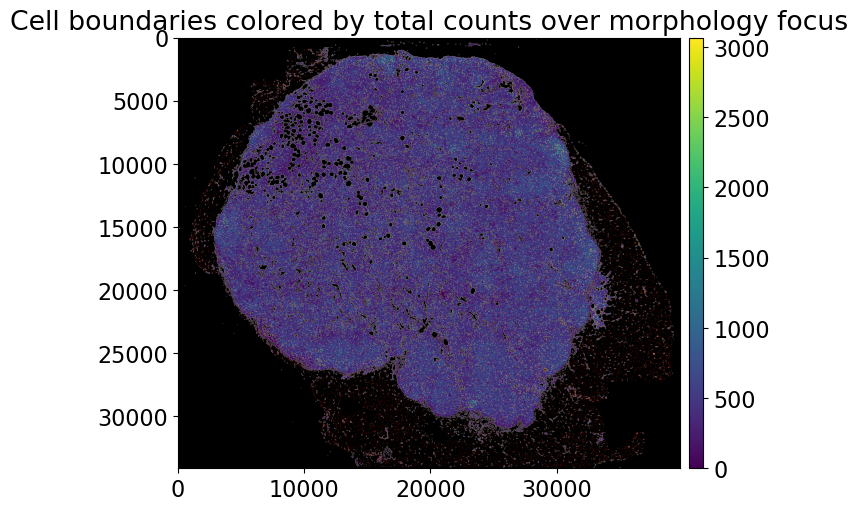

In [8]:
sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")

sdata.pl.render_images("morphology_focus").pl.render_shapes(
    "cell_boundaries",
    color='total_counts',
).pl.show(title="Cell boundaries colored by total counts over morphology focus", coordinate_systems="global", figsize=(10, 5))

In [10]:
adata = sdata.tables['table']
adata.obs

,cell_id,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,nucleus_count,segmentation_method,region,z_level,cell_labels
0,aaaaadoa-1,271,0,0,0,0,0,271,87.332191,46.646408,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_boundaries,0.0,1
1,aaaaclhf-1,315,0,0,0,0,0,315,43.530627,21.900782,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_boundaries,0.0,2
2,aaaafcfj-1,337,0,0,0,0,0,337,58.206408,27.996876,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_boundaries,0.0,3
3,aaaagamp-1,235,0,0,0,0,0,235,34.273595,23.120001,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_boundaries,0.0,4
4,aaaaiako-1,102,0,0,0,0,0,102,19.823594,NaN,0.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_boundaries,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708978,oikoinno-1,92,0,0,0,0,0,92,19.823594,19.823594,1.0,Segmented by nucleus expansion of 5.0µm,cell_boundaries,5.0,708979
708979,oikojopg-1,118,0,0,0,0,0,118,13.095313,13.095313,1.0,Segmented by nucleus expansion of 5.0µm,cell_boundaries,5.0,708980
708980,oikokaeg-1,43,0,0,0,0,0,43,7.676563,7.676563,1.0,Segmented by nucleus expansion of 5.0µm,cell_boundaries,6.0,708981
708981,oikooakd-1,20,0,0,0,0,0,20,13.275938,13.275938,1.0,Segmented by nucleus expansion of 5.0µm,cell_boundaries,4.0,708982


In [11]:
set(adata.obs['segmentation_method'])

{'Segmented by boundary stain (ATP1A1+CD45+E-Cadherin)',
 'Segmented by interior stain (18S)',
 'Segmented by nucleus expansion of 5.0µm'}

In [12]:
adata.obs['segmentation_method'] = adata.obs['segmentation_method'].astype(str)
idx = adata.obs['segmentation_method'] == 'Segmented by boundary stain (ATP1A1+CD45+E-Cadherin)'
adata = adata[idx]  # Use boolean indexing directly
adata

View of AnnData object with n_obs × n_vars = 402931 × 4624
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [13]:
adata.write_h5ad('data/xenium_lymph.h5ad')

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


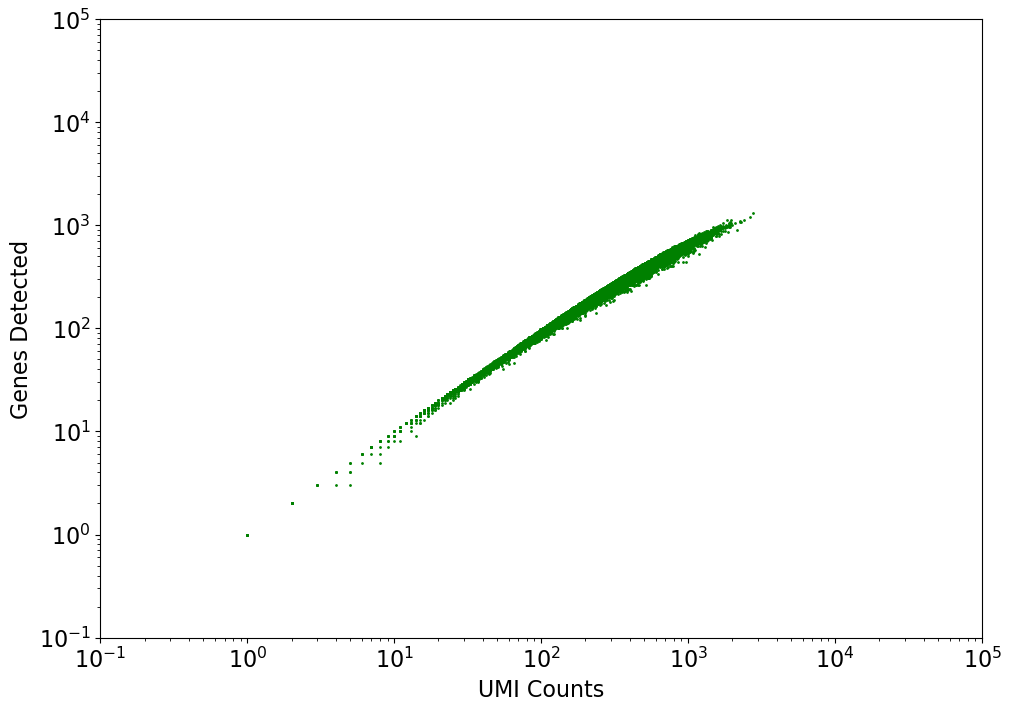

In [14]:
mtx = adata.X

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", s=1, alpha=1)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((1e-1,1e5))
ax.set_ylim((1e-1,1e5))

plt.show()

In [15]:
import statistics

statistics.median(mtx.sum(axis=1))

matrix([[302.]], dtype=float32)

In [25]:
adata.obs_names = adata.obs_names.astype(str)  # Convert index to string
idx = (mtx.sum(axis=1) >= 100) 
adata = adata[idx]
adata

IndexError: Boolean index does not match AnnData’s shape along this dimension. Boolean index has shape (402931, 1) while AnnData index has shape (402859,).

R² = 0.26
Pearson correlation = 0.75
CCC = 0.73
MSE = 0.0757
RMSE = 0.2752
Estimated slope from regression: [0.99824102]


(0.10227344363953368, 0.17414500657163928)

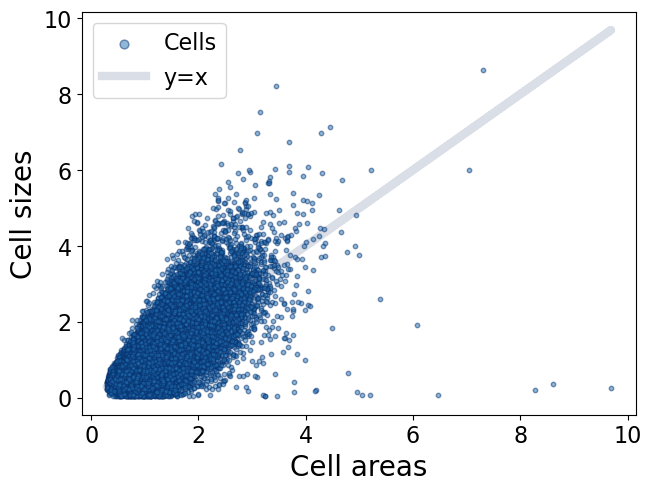

In [26]:
x = np.array(adata.obs['cell_area'].tolist())
y = np.array(adata.obs['transcript_counts'].tolist())
x = x/x.mean()
y = y/y.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.scatter(x,y,color='#2070b4',edgecolor='#08326e',s=10,alpha=0.5,label='Cells')
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
plt.legend(loc='upper left',fontsize=16, markerscale=2)
plt.xlabel('Cell areas',fontsize=20)
plt.ylabel('Cell sizes',fontsize=20)

# Clean invalid values
mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
x_clean = x[mask]
y_clean = y[mask]

# Compute R² only if enough valid points exist
if len(x_clean) > 1 and len(y_clean) > 1:
    ss_total = np.sum((x_clean - np.mean(x_clean)) ** 2)
    ss_residual = np.sum((y_clean - x_clean) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    print(f'R² = {np.around(r2, 2)}')
    r = np.corrcoef(x_clean, y_clean)[0, 1]
    print(f'Pearson correlation = {r:.2f}')
    ccc = CCC(x_clean, y_clean)
    print(f'CCC = {ccc:.2f}')
    mse = np.mean((y_clean - x_clean) ** 2)
    print(f'MSE = {np.around(mse, 4)}')
    rmse = np.sqrt(mse)
    print(f'RMSE = {np.around(rmse, 4)}')
    
# Perform linear regression
model = LinearRegression(fit_intercept=False)  # No intercept since y = ax
model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
a_estimated = model.coef_[0]
print(f"Estimated slope from regression: {a_estimated}")

x.var(),y.var()

In [48]:
adata = adata[x<6]

In [49]:
PBMC_Pgenes = np.loadtxt('results/pbmc_Pgenes.txt', dtype=str)

In [50]:
Pgene_mask = adata.var['gene_ids'].isin(PBMC_Pgenes)
Pgene_mask.sum()

203

R² = -0.16
Pearson correlation = 0.61
CCC = 0.58
MSE = 0.1173
RMSE = 0.3425
Estimated slope from regression: [0.98233618]


(0.10150884214318692, 0.17991808)

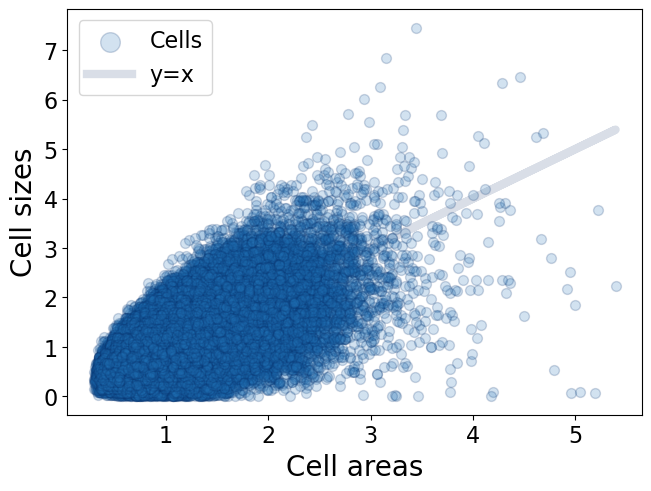

In [51]:
x = np.array(adata.obs['cell_area'].tolist())
y = adata.X.toarray()[:,Pgene_mask].sum(1) 

x = x/x.mean()
y = y/y.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.scatter(x,y,alpha=0.2,s=50,c='#2070b4',edgecolor='#08326e',label='Cells')
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
plt.legend(loc='upper left',fontsize=16, markerscale=2)
plt.xlabel('Cell areas',fontsize=20)
plt.ylabel('Cell sizes',fontsize=20)

# Clean invalid values
mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
x_clean = x[mask]
y_clean = y[mask]

# Compute R² only if enough valid points exist
if len(x_clean) > 1 and len(y_clean) > 1:
    ss_total = np.sum((x_clean - np.mean(x_clean)) ** 2)
    ss_residual = np.sum((y_clean - x_clean) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    print(f'R² = {np.around(r2, 2)}')
    r = np.corrcoef(x_clean, y_clean)[0, 1]
    print(f'Pearson correlation = {r:.2f}')
    ccc = CCC(x_clean, y_clean)
    print(f'CCC = {ccc:.2f}')
    mse = np.mean((y_clean - x_clean) ** 2)
    print(f'MSE = {np.around(mse, 4)}')
    rmse = np.sqrt(mse)
    print(f'RMSE = {np.around(rmse, 4)}')
    
# Perform linear regression
model = LinearRegression(fit_intercept=False)  # No intercept since y = ax
model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
a_estimated = model.coef_[0]
print(f"Estimated slope from regression: {a_estimated}")

x.var(),y.var()

R² = 0.26
Pearson correlation = 0.75
CCC = 0.73
MSE = 0.0751
RMSE = 0.274
Estimated slope from regression: [0.99881193]


(0.10150884214318692, 0.17394212450192945)

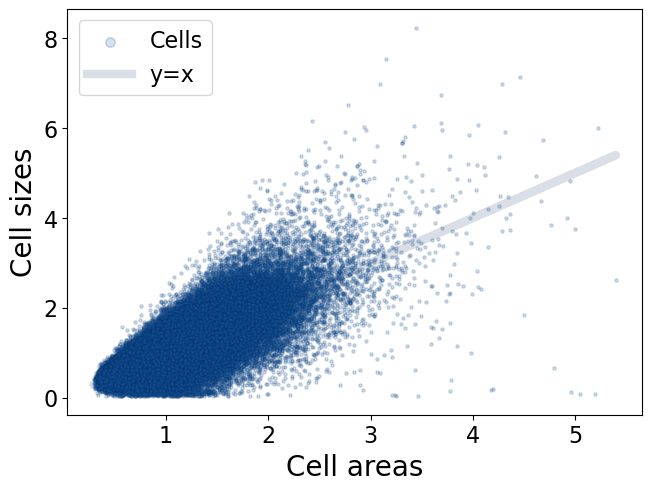

In [52]:
x = np.array(adata.obs['cell_area'].tolist())
y = np.array(adata.obs['transcript_counts'].tolist())
x = x/x.mean()
y = y/y.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.scatter(x,y,color='#2070b4',edgecolor='#08326e',s=5,alpha=0.2,label='Cells')
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
plt.legend(loc='upper left',fontsize=16, markerscale=3)
plt.xlabel('Cell areas',fontsize=20)
plt.ylabel('Cell sizes',fontsize=20)

# Clean invalid values
mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
x_clean = x[mask]
y_clean = y[mask]

# Compute R² only if enough valid points exist
if len(x_clean) > 1 and len(y_clean) > 1:
    ss_total = np.sum((x_clean - np.mean(x_clean)) ** 2)
    ss_residual = np.sum((y_clean - x_clean) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    print(f'R² = {np.around(r2, 2)}')
    r = np.corrcoef(x_clean, y_clean)[0, 1]
    print(f'Pearson correlation = {r:.2f}')
    ccc = CCC(x_clean, y_clean)
    print(f'CCC = {ccc:.2f}')
    mse = np.mean((y_clean - x_clean) ** 2)
    print(f'MSE = {np.around(mse, 4)}')
    rmse = np.sqrt(mse)
    print(f'RMSE = {np.around(rmse, 4)}')
    
# Perform linear regression
model = LinearRegression(fit_intercept=False)  # No intercept since y = ax
model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
a_estimated = model.coef_[0]
print(f"Estimated slope from regression: {a_estimated}")

x.var(),y.var()

R² = -0.16
Pearson correlation = 0.61
CCC = 0.58
MSE = 0.1173
RMSE = 0.3425
Estimated slope from regression: [0.98233618]


(0.10150884214318692, 0.17991808)

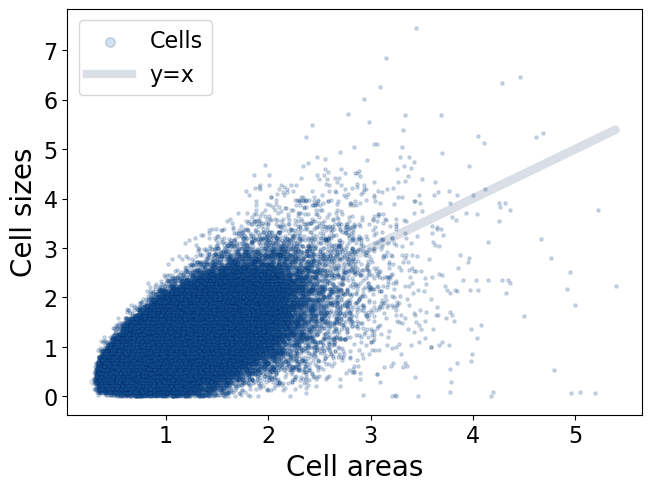

In [53]:
x = np.array(adata.obs['cell_area'].tolist())
y = adata.X.toarray()[:,Pgene_mask].sum(1) 

x = x/x.mean()
y = y/y.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.scatter(x,y,alpha=0.2,s=5,c='#2070b4',edgecolor='#08326e',label='Cells')
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
plt.legend(loc='upper left',fontsize=16, markerscale=3)
plt.xlabel('Cell areas',fontsize=20)
plt.ylabel('Cell sizes',fontsize=20)

# Clean invalid values
mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
x_clean = x[mask]
y_clean = y[mask]

# Compute R² only if enough valid points exist
if len(x_clean) > 1 and len(y_clean) > 1:
    ss_total = np.sum((x_clean - np.mean(x_clean)) ** 2)
    ss_residual = np.sum((y_clean - x_clean) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    print(f'R² = {np.around(r2, 2)}')
    r = np.corrcoef(x_clean, y_clean)[0, 1]
    print(f'Pearson correlation = {r:.2f}')
    ccc = CCC(x_clean, y_clean)
    print(f'CCC = {ccc:.2f}')
    mse = np.mean((y_clean - x_clean) ** 2)
    print(f'MSE = {np.around(mse, 4)}')
    rmse = np.sqrt(mse)
    print(f'RMSE = {np.around(rmse, 4)}')
    
# Perform linear regression
model = LinearRegression(fit_intercept=False)  # No intercept since y = ax
model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
a_estimated = model.coef_[0]
print(f"Estimated slope from regression: {a_estimated}")

x.var(),y.var()

Text(0, 0.5, 'Cell sizes')

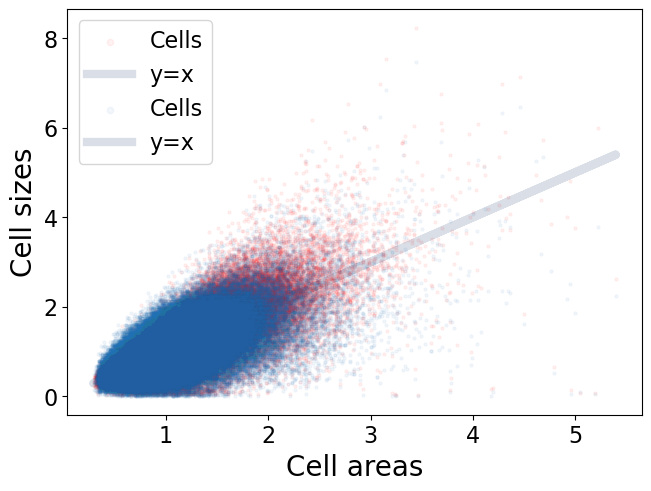

In [54]:
x = adata.obs['cell_area']
y = adata.obs['transcript_counts']
x = x/x.mean()
y = y/y.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.scatter(x,y,color='r',s=5,alpha=0.05,label='Cells')
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')

y = adata.X.toarray()[:,Pgene_mask].sum(1) 
y = y/y.mean()

ax.scatter(x,y,color='#2070b4',s=5,alpha=0.05,label='Cells')
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
plt.legend(loc='upper left',fontsize=16, markerscale=2)
plt.xlabel('Cell areas',fontsize=20)
plt.ylabel('Cell sizes',fontsize=20)

R² = 0.73
Pearson correlation = 0.87
CCC = 0.87
MSE = 0.0464
RMSE = 0.2155


(0.17393468018861155, 0.17991808)

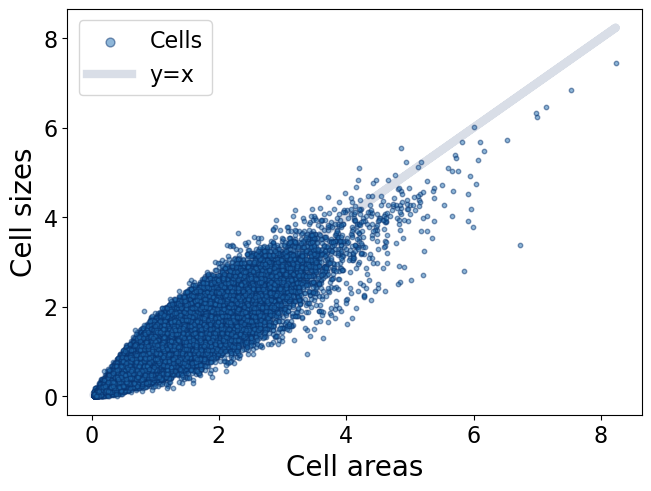

In [55]:
x = adata.obs['total_counts']
y = adata.X.toarray()[:,Pgene_mask].sum(1) 

x = x/x.mean()
y = y/y.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.scatter(x,y,color='#2070b4',edgecolor='#08326e',s=10,alpha=0.5,label='Cells')
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
plt.legend(loc='upper left',fontsize=16, markerscale=2)
plt.xlabel('Cell areas',fontsize=20)
plt.ylabel('Cell sizes',fontsize=20)

# Clean invalid values
mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
x_clean = x[mask]
y_clean = y[mask]

if len(x_clean) > 1 and len(y_clean) > 1:
    ss_total = np.sum((x_clean - np.mean(x_clean)) ** 2)
    ss_residual = np.sum((y_clean - x_clean) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    print(f'R² = {np.around(r2, 2)}')
    r = np.corrcoef(x_clean, y_clean)[0, 1]
    print(f'Pearson correlation = {r:.2f}')
    ccc = CCC(x_clean, y_clean)
    print(f'CCC = {ccc:.2f}')
    mse = np.mean((y_clean - x_clean) ** 2)
    print(f'MSE = {np.around(mse, 4)}')
    rmse = np.sqrt(mse)
    print(f'RMSE = {np.around(rmse, 4)}')

x.var(),y.var()

# Calculate CV$^2$ of read depth

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


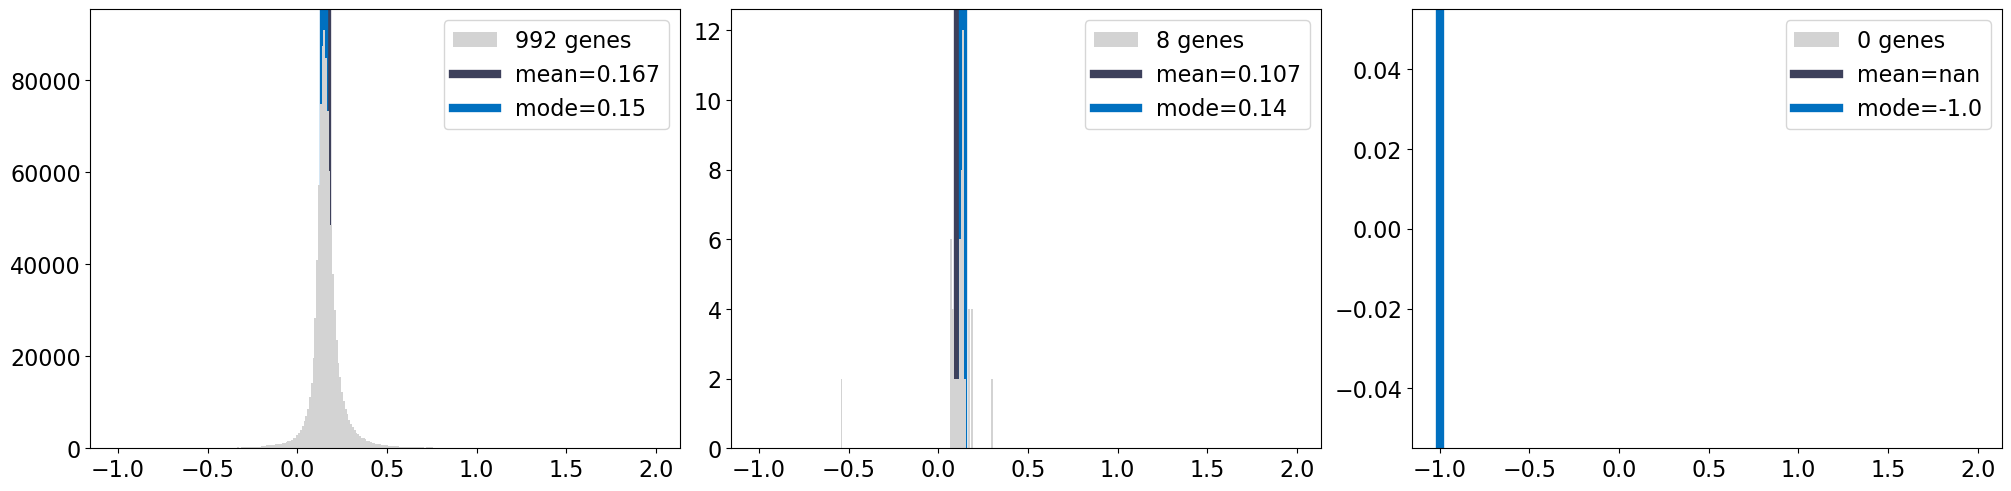

In [23]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.X.toarray(),ax=axs[0],min_mean=0.1,max_mean=1,bins=np.arange(-1,2,0.01)-0.005)
s = estimate_s(N1=adata.X.toarray(),ax=axs[1],min_mean=1,max_mean=10,bins=np.arange(-1,2,0.01)-0.005)
s = estimate_s(N1=adata.X.toarray(),ax=axs[2],min_mean=10,bins=np.arange(-1,2,0.01)-0.005)

Text(0.5, 0, 'Values')

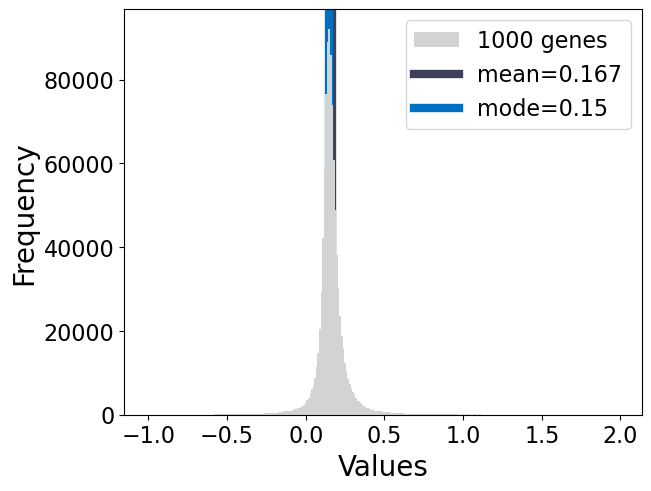

In [22]:
fig,axs = plt.subplots(1,1)

_ = estimate_s(N1=adata.X.toarray(),ax=axs,min_mean=0.1,bins=np.arange(-1.,2.,0.01)-0.005)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Values',fontsize=20)

# Variance plots

In [24]:
X_ = adata.X.toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(overdispersion,[X_],B=1000,n_cores=50,alpha=0.05)


KeyboardInterrupt



In [ ]:
s = 0.15

Pgene_mask = (s < upper_bound) & (s > lower_bound) 
Pgene = adata.var_names[nonzero_idx][Pgene_mask]

fig,axs = plt.subplots(1,1)

idx = adata.var_names.isin(Pgene)
X_ = adata.X.toarray()[:,idx]
_ = estimate_s(X_,ax=axs,min_mean=0.1)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Values',fontsize=20)

In [ ]:
X_ = adata.X.toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='"Poisson" genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([2e-4,2e3])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

In [ ]:
# Save to text file (each string will be on a new line)
np.savetxt("results/xenium_Pgenes.txt", np.array(Pgene), fmt='%s')

In [ ]:
X_ = adata.X.toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
cellsize_S = X_[:,Pgene_mask].sum(1)
cellsize_S = cellsize_S/cellsize_S.mean()

cellsize_X = adata.X.toarray().copy().sum(1)
cellsize_X = cellsize_X/cellsize_X.mean()

x = cellsize_S/cellsize_S.mean()
y = cellsize_X/cellsize_X.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.scatter(cellsize_S,cellsize_X,color='#2070b4',edgecolor='#08326e',s=50,alpha=1,label='Cells')
ax.plot(cellsize_S,cellsize_S,zorder=0,color='#d9dee7',label='y=x')
plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Using Poisson counts',fontsize=20)
plt.ylabel('Using total counts',fontsize=20)

# Clean invalid values
mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
x_clean = x[mask]
y_clean = y[mask]

if len(x_clean) > 1 and len(y_clean) > 1:
    ss_total = np.sum((x_clean - np.mean(x_clean)) ** 2)
    ss_residual = np.sum((y_clean - x_clean) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    print(f'R² = {np.around(r2, 2)}')
    r = np.corrcoef(x_clean, y_clean)[0, 1]
    print(f'Pearson correlation = {r:.2f}')
    ccc = CCC(x_clean, y_clean)
    print(f'CCC = {ccc:.2f}')
    mse = np.mean((y_clean - x_clean) ** 2)
    print(f'MSE = {np.around(mse, 4)}')
    rmse = np.sqrt(mse)
    print(f'RMSE = {np.around(rmse, 4)}')

cellsize_S.var(),cellsize_X.var()

In [ ]:
x = adata.obs['cell_area'] #- adata.obs['nucleus_area']

X_ = adata.X.toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
y = X_[:,Pgene_mask].sum(1)
x = x/x.mean()
y = y/y.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.scatter(x,y,color='#2070b4',edgecolor='#08326e',s=50,alpha=1,label='Cells')
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Cell areas',fontsize=20)
plt.ylabel('Cell sizes',fontsize=20)


# Clean invalid values
mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
x_clean = x[mask]
y_clean = y[mask]

# Compute R² only if enough valid points exist
if len(x_clean) > 1 and len(y_clean) > 1:
    ss_total = np.sum((x_clean - np.mean(x_clean)) ** 2)
    ss_residual = np.sum((y_clean - x_clean) ** 2)
    r2 = 1 - (ss_residual / ss_total) 
    print(f'R² = {np.around(r2, 2)}')
    r = np.corrcoef(x_clean, y_clean)[0, 1]
    print(f'Pearson correlation = {r:.2f}')
    ccc = CCC(x_clean, y_clean)
    print(f'CCC = {ccc:.2f}')
    mse = np.mean((y_clean - x_clean) ** 2)
    print(f'MSE = {np.around(mse, 4)}')
    rmse = np.sqrt(mse)
    print(f'RMSE = {np.around(rmse, 4)}')

cellsize_S.var(),cellsize_X.var()